In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal
import scipy.signal
from pycsou.abc import DiffMap, Map, DiffFunc, LinOp, Mode, ProxFunc
from pycsou.operator import *
from pycsou.operator.interop import from_torch, from_sciop, from_source
from pycsou.opt.solver import PGD, CG, CP, CV
from pycsou.opt.stop import RelError, MaxIter
import time as t
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import xdesign
import skimage
import skimage.transform as skt

from radon_op import *
from disk_func import *
from gaussian_func import *

## Measurements: sinogram with faulty detectors, uniform filtering,  tapering, and noise

/home/dicedead/Projects/LCAV/pycsou_perso/venv/lib/python3.11/site-packages/xdesign/phantom/phantom.py:375: RuntimeWarning: Reached termination criteria of 500 attempts before adding all of the circles.
  warnings.warn((
/home/dicedead/Projects/LCAV/pycsou_perso/venv/lib/python3.11/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


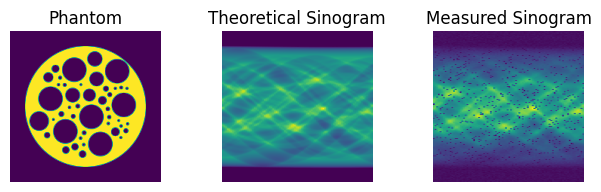

In [3]:
import xdesign as xdesign

# Generate phantom
np.random.seed(0)
p1 = xdesign.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
phantom = xdesign.discrete_phantom(p1, 160) * 10
phantom = np.abs(np.pad(phantom, 20))

# Generate sinogram 
rng = np.random.default_rng(0)
psnr = 20 # 10 * log(s/n) = psnr => n = s * 10^(-psnr/10)
angles, wsize = 90, 5
sino0 = skt.radon(phantom, theta=np.linspace(0, 180, angles), circle=True)
sino = sp.ndimage.uniform_filter(sino0, [wsize, 0], mode='constant')
mask = rng.binomial(1, 0.95, sino.shape)
sino *= mask
sino *= scipy.signal.get_window('hamming', sino.shape[0])[:, None]
sigma = np.abs(sino).max() * (10**(-psnr/10))
sino += rng.normal(scale=sigma, size=sino.shape)

plt.figure(figsize=(6.5,2))
_ = plt.subplot(1,3,1)
_ = plt.imshow(phantom)
_ = plt.title("Phantom")
_ = plt.axis('off')

_ = plt.subplot(1,3,2)
_ = plt.imshow(sino0, aspect=0.45)
_ = plt.title("Theoretical Sinogram")
_ = plt.axis('off')

_ = plt.subplot(1,3,3)
_ = plt.imshow(sino, aspect=0.45)
_ = plt.title("Measured Sinogram")
_ = plt.axis('off')
plt.tight_layout()
plt.show()

## Reconstruction with simple filtered backprojection

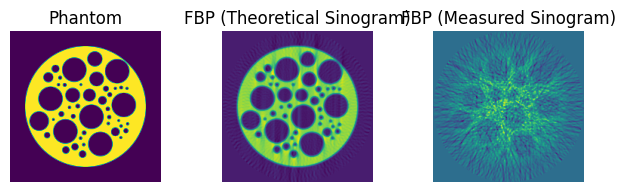

In [4]:
plt.figure(figsize=(6.5,2))
_ = plt.subplot(1,3,1)
_ = plt.imshow(phantom)
_ = plt.title('Phantom')
_ = plt.axis('off')
_ = plt.subplot(1,3,2)
_ = plt.imshow(skt.iradon(radon_image=sino0, circle=True, filter_name="hamming"))
_ = plt.title('FBP (Theoretical Sinogram)')
_ = plt.axis('off')
_ = plt.subplot(1,3,3)
_ = plt.imshow(skt.iradon(radon_image=sino, circle=True, filter_name="hamming"))
_ = plt.title('FBP (Measured Sinogram)')
_ = plt.axis('off')
plt.tight_layout()
plt.show()

## More accurate forward model
$\mathbf{H} \in \mathbb{R}^{M \times N}$ where $M = n_\theta \times n_d$:
* $n_\theta$: number of angles
* $n_d$: number of detectors

In [5]:
# Radon Operator
Radon = from_source(cls=LinOp,
                    shape=(sino.size, phantom.size),
                    apply=lambda self, arr: skt.radon(arr.reshape(phantom.shape), 
                                                      theta=np.linspace(0, 180, angles), 
                                                      circle=True).ravel(),
                    adjoint=lambda self, arr: skt.iradon(arr.reshape(sino.shape), 
                                                         filter_name=None, 
                                                         circle=True).ravel(),
                    vectorize=["apply", "adjoint"], vmethod="scan", enforce_precision=["apply", "adjoint"])

# 1D Filtering
boxcar = np.asarray(scipy.signal.get_window("boxcar", wsize)); boxcar /= wsize
BoxCar1D = Stencil(kernel=[boxcar, np.array([1.0])], center=(wsize // 2, 0), arg_shape=sino.shape,)

# Partial Masking
Mask = DiagonalOp(mask.ravel())

# Tapering
taper = np.outer(scipy.signal.get_window("hamming", sino.shape[0]), np.ones(sino.shape[1]))
Taper = DiagonalOp(taper.ravel())

# Compose operators
Phi = Taper * Mask * BoxCar1D * Radon

predicted_sino = Phi(phantom.ravel()).reshape(sino.shape)

/home/dicedead/Projects/LCAV/pycsou_perso/venv/lib/python3.11/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
/home/dicedead/Projects/LCAV/pycsou_perso/src/pycsou/operator/linop/base.py:254: PrecisionWarning: Computation may not be performed at the requested precision.
  warnings.warn(msg, pycuw.PrecisionWarning)


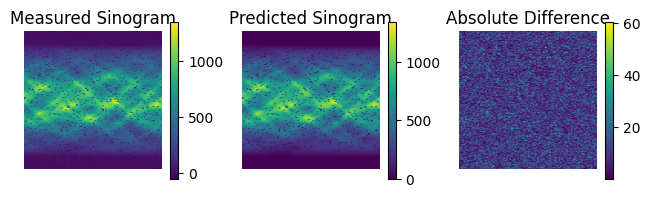

In [6]:
plt.figure(figsize=(6.5,2))
_ = plt.subplot(1,3,1)
_ = plt.imshow(sino, aspect=0.45)
_ = plt.colorbar()
_ = plt.title("Measured Sinogram")
_ = plt.axis('off')

_ = plt.subplot(1,3,2)
_ = plt.imshow(predicted_sino, aspect=0.45)
_ = plt.colorbar()
_ = plt.title("Predicted Sinogram")
_ = plt.axis('off')

_ = plt.subplot(1,3,3)
_ = plt.imshow(np.abs(sino-predicted_sino), aspect=0.45)
_ = plt.colorbar()
_ = plt.title("Absolute Difference")
_ = plt.axis('off')
plt.tight_layout()
plt.show()

## Pseudo-Inverse Solution

Least squares with dampening parameter $\lambda$

$$\hat{\mathbf{x}}\in \arg\min_{\mathbf{x}\in\mathbb{R}^{N}} \frac12 \|\mathbf{H}\mathbf{x} - \mathbf{y}\|_2^2 + \frac{\lambda}{2} \|\mathbf{x}\|_2^2 = (\mathbf{H}^T \mathbf{H} + \lambda \mathbf{I} )^{-1} \mathbf{H}^T \mathbf{y}$$

In [7]:
default_stop_crit = RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) | MaxIter(500)
pinv_solution = Phi.pinv(sino.ravel(), damp=4,  
                         kwargs_init=dict(show_progress=False, verbosity=50),
                         kwargs_fit=dict(stop_crit=default_stop_crit))

INFO:/tmp/pycsou_ud7d5_t7:[2023-07-14 09:18:41.948868] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	N_iter: 1.0
/home/dicedead/Projects/LCAV/pycsou_perso/src/pycsou/operator/linop/base.py:254: PrecisionWarning: Computation may not be performed at the requested precision.
  warnings.warn(msg, pycuw.PrecisionWarning)
/home/dicedead/Projects/LCAV/pycsou_perso/src/pycsou/operator/linop/base.py:254: PrecisionWarning: Computation may not be performed at the requested precision.
  warnings.warn(msg, pycuw.PrecisionWarning)
/home/dicedead/Projects/LCAV/pycsou_perso/src/pycsou/operator/linop/base.py:254: PrecisionWarning: Computation may not be performed at the requested precision.
  warnings.warn(msg, pycuw.PrecisionWarning)
/home/dicedead/Projects/LCAV/pycsou_perso/src/pycsou/operator/linop/base.py:254: PrecisionWarning: Computation may not be performed at the requested precision.
  warnings.warn(msg, pycuw.PrecisionWarning)
/home/dicedead/Projects/LCAV/pycsou_perso/src/pycsou/operator/linop/

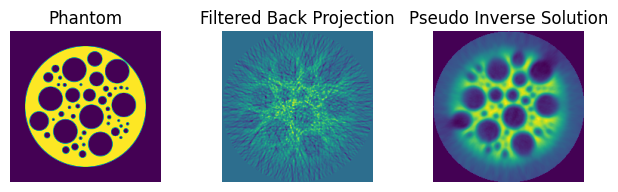

In [8]:
plt.figure(figsize=(6.5,2))
_ = plt.subplot(1,3,1)
_ = plt.imshow(phantom)
_ = plt.title('Phantom')
_ = plt.axis('off')
_ = plt.subplot(1,3,2)
_ = plt.imshow(skt.iradon(radon_image=sino, circle=True, filter_name="hamming"))
_ = plt.title('Filtered Back Projection')
_ = plt.axis('off')
_ = plt.subplot(1,3,3)
_ = plt.imshow(pinv_solution.reshape(phantom.shape))
_ = plt.title('Pseudo Inverse Solution')
_ = plt.axis('off')
plt.tight_layout()
plt.show()

## Custom Solution

In [9]:
phantom.shape

(200, 200)

In [10]:
sino.shape

(200, 90)

In [80]:
deltas = {
    "start": [-100, -100],
    "stop": [100, 100],
    "num": [200, 200]
}


n = {
    "start": 0.,
    "stop": np.pi,
    "num": sino.shape[1]
}


t = {
    "start": -100,
    "stop": 100,
    "num": 200
}

gaussian_sigma = 0.5
gaussian = TruncatedGaussian(gaussian_sigma)

disk_radius = 0.6
disk = Disk(disk_radius)

eps = 1e-3

radon_op = RadonOp.uniform(deltas, gaussian, n, t, eps=eps)
Phi_prime = Taper * Mask * BoxCar1D * radon_op

computed_sinogram = Phi_prime(phantom.ravel()).reshape(sino.shape)

/home/dicedead/Projects/LCAV/pycsou_perso/src/pycsou/operator/linop/base.py:254: PrecisionWarning: Computation may not be performed at the requested precision.
  warnings.warn(msg, pycuw.PrecisionWarning)


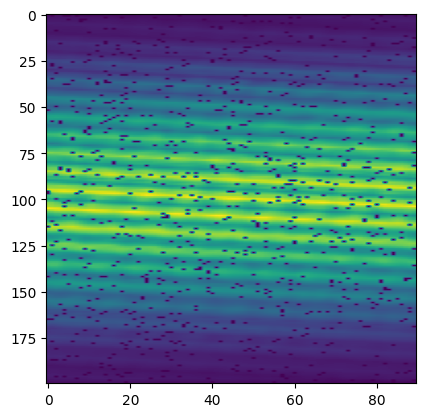

In [81]:
plt.imshow(computed_sinogram, aspect=0.45);

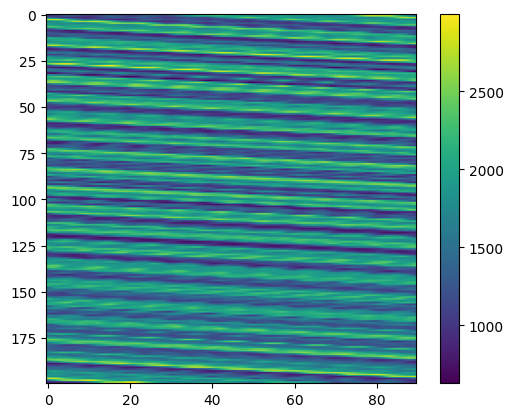

In [82]:
plt.imshow(radon_op(phantom.ravel()).reshape(sino.shape), aspect=0.45)
plt.colorbar();

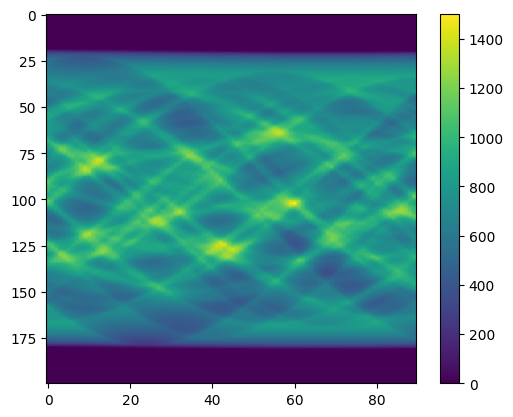

In [83]:
plt.imshow(sino0, aspect=0.45)
plt.colorbar();

In [84]:
import time

start = time.time()
ski_radon = skt.radon(phantom, theta=np.linspace(0, 180, angles), circle=True)
end = time.time()
print(end-start)

0.07263922691345215


/home/dicedead/Projects/LCAV/pycsou_perso/venv/lib/python3.11/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


In [85]:
start = time.time()
radon_op(phantom.ravel())
end = time.time()
print(end-start)

0.013927936553955078


In [71]:
non_unif_deltas = np.array([[0., 0.]])
non_unif_n = np.linspace(0,2*np.pi, 200)
non_unif_t = {
    "start": -0.3,
    "stop": 0.3,
    "num": 10
}

non_unif_radon_disk = RadonOp.nonuniform(non_unif_deltas, disk, non_unif_n, non_unif_t)
non_unif_radon_gaussian = RadonOp.nonuniform(non_unif_deltas, gaussian, non_unif_n, non_unif_t)

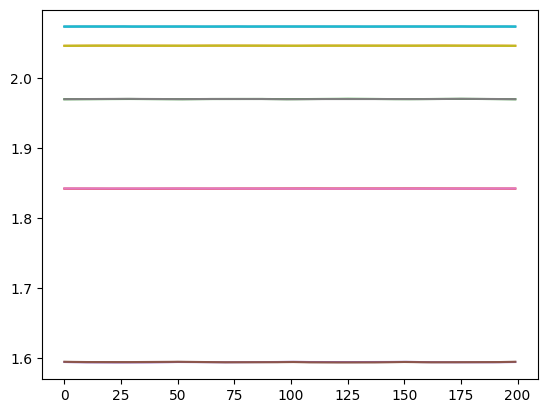

In [72]:
plt.plot(non_unif_radon_disk(np.ones(len(non_unif_deltas))).reshape(len(non_unif_n), non_unif_t["num"]));

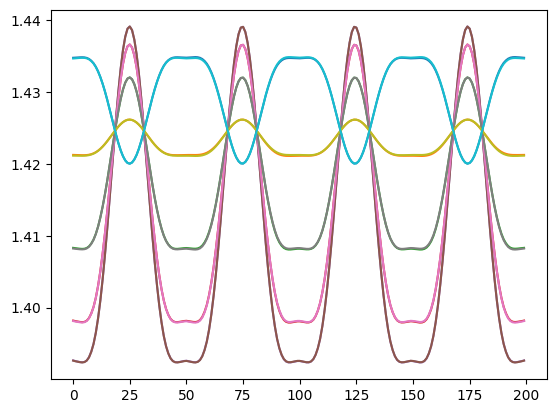

In [73]:
plt.plot(non_unif_radon_gaussian(np.ones(len(non_unif_deltas))).reshape(len(non_unif_n), non_unif_t["num"]));

In [64]:
from radon_transform import *
import gaussian_radon_test

non_unif_n_angles = np.array(list(zip([np.cos(non_unif_n), np.sin(non_unif_n)]))).reshape(-1, 2)
old_radon_op_gaussian = RadonTransform(gaussian, non_unif_deltas, non_unif_n_angles, np.linspace(**non_unif_t))

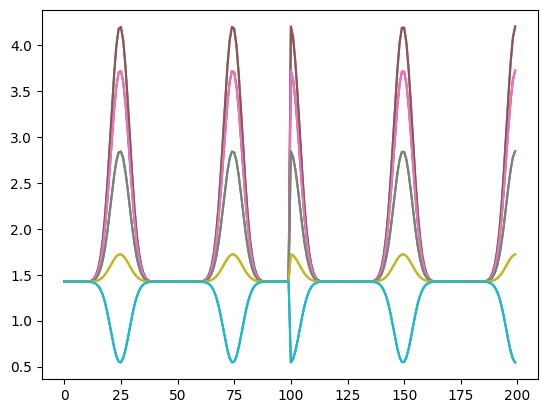

In [65]:
plt.plot(old_radon_op_gaussian.apply(np.ones(len(non_unif_deltas))).reshape(len(non_unif_n), non_unif_t["num"]));

In [66]:
import disk_radon_test

old_radon_op_disk = RadonTransform(disk, non_unif_deltas, non_unif_n_angles, np.linspace(**non_unif_t))

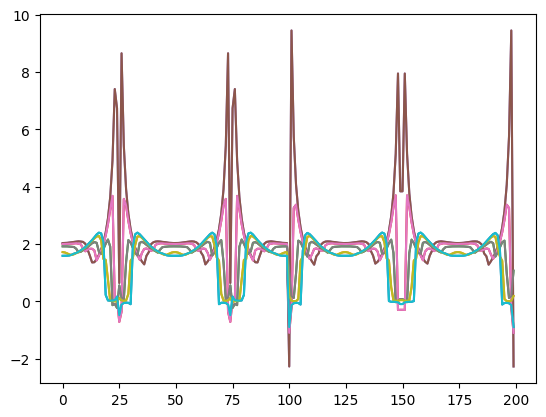

In [67]:
plt.plot(old_radon_op_disk.apply(np.ones(len(non_unif_deltas))).reshape(len(non_unif_n), non_unif_t["num"]));